In [1]:
import torch
from torchvision import datasets, transforms, utils

## Data

In [2]:
# Define transformation (e.g., convert to tensor)
transform = transforms.ToTensor()

# Download and load training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Combine train and test datasets
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

ind = [i for i in range(len(dataset)) if dataset[i][1] == 3]

dataset = torch.utils.data.Subset(dataset, ind)

# Wrap the combined dataset with DataLoader for batching
dataloader = torch.utils.data.DataLoader(dataset = dataset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 432kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.14MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.03MB/s]


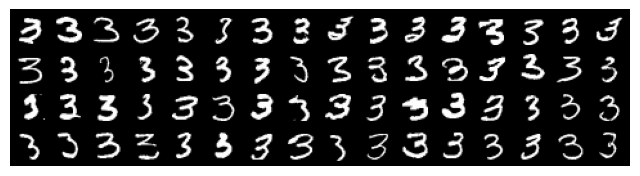

In [3]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(iter(dataloader))

# Create a grid of images
grid = utils.make_grid(images, nrow=16, padding=2, normalize=True)

# Display the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plotting
plt.axis('off')
plt.show()

In [4]:
def get_noise(t, sigma_min = 0.01, sigma_max = 5):
  return sigma_min*(sigma_max/sigma_min)**t

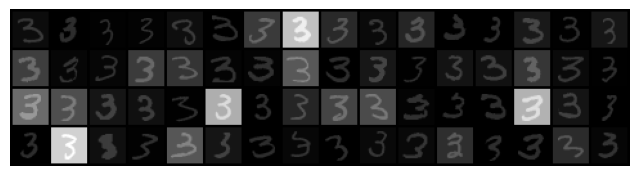

In [5]:
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(dataloader))

# Get a batch of images and labels
imgs = images

for i in range(len(imgs)):
  t = np.random.uniform(0, 1)
  imgs[i] += get_noise(t)

# Create a grid of images
grid = utils.make_grid(imgs, nrow=16, padding=2, normalize=True)

# Display the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for plotting
plt.axis('off')
plt.show()

## Model

In [6]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(2, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        x2 = torch.reshape(x, (*x.shape[:-1], 1, 28, 28))  # (..., ch0, 28, 28)
        tt = t[..., None, None].expand(*t.shape[:-1], 1, 28, 28)  # (..., 1, 28, 28)
        x2t = torch.cat((x2, tt), dim=-3)
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, (*signal.shape[:-3], -1))  # (..., 1 * 28 * 28)
        return signal

score_network = ScoreNetwork0()

In [7]:
def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, nch) is the training data

    # sample the time
    t = torch.rand((x.shape[0], 1), dtype=x.dtype, device=x.device) * (1 - 1e-4) + 1e-4

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    mu_t = x * torch.exp(-0.5 * int_beta)
    var_t = -torch.expm1(-int_beta)
    x_t = torch.randn_like(x) * var_t ** 0.5 + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, nch)

    # calculate the score function
    score = score_network(x_t, t)  # score: (batch_size, nch)

    # calculate the loss function
    loss = (score - grad_log_p) ** 2
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return torch.mean(weighted_loss)

In [9]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda:0')  # change this if you don't have a gpu
score_network = score_network.to(device)
t0 = time.time()
for i_epoch in range(400):
    total_loss = 0
    for data, _ in dloader:  # we don't need the data class
        data = data.reshape(data.shape[0], -1).to(device)
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()

        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]

    # print the training stats
    if i_epoch % 20 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dataset)}")

0 (3.1060314178466797s): 0.30214515107425216
20 (42.101534605026245s): 0.0917105084581713
40 (81.04377508163452s): 0.06506763670284146
60 (119.57134294509888s): 0.04891359852072639
80 (158.2568998336792s): 0.040550620788482705
100 (196.71751308441162s): 0.03302573482926579
120 (235.1703770160675s): 0.030803733387540208
140 (273.55475878715515s): 0.031709774886515524
160 (312.281929731369s): 0.028890127738022978
180 (350.6874952316284s): 0.028558143198452582
200 (388.9830849170685s): 0.02628840858938647
220 (427.3889465332031s): 0.02557547437829174
240 (465.8992943763733s): 0.02444660106011047
260 (504.50268054008484s): 0.023776846716253217
280 (542.878279209137s): 0.023200469978384288
300 (581.3257632255554s): 0.02254869356441566
320 (619.7741343975067s): 0.022688513542393096
340 (658.4654211997986s): 0.02654712030239181
360 (696.9144430160522s): 0.022357166832540652
380 (735.3363916873932s): 0.02349176437148876


In [10]:
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    device = next(score_network.parameters()).device
    x_t = torch.randn((nsamples, 28 * 28), device=device)  # (nsamples, nch)
    time_pts = torch.linspace(1, 0, 1000, device=device)  # (ntime_pts,)
    beta = lambda t: 0.1 + (20 - 0.1) * t
    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(x_t, t.expand(x_t.shape[0], 1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt

        # euler-maruyama step
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5
    return x_t

In [15]:
samples = generate_samples(score_network, 20).detach().reshape(-1, 28, 28)

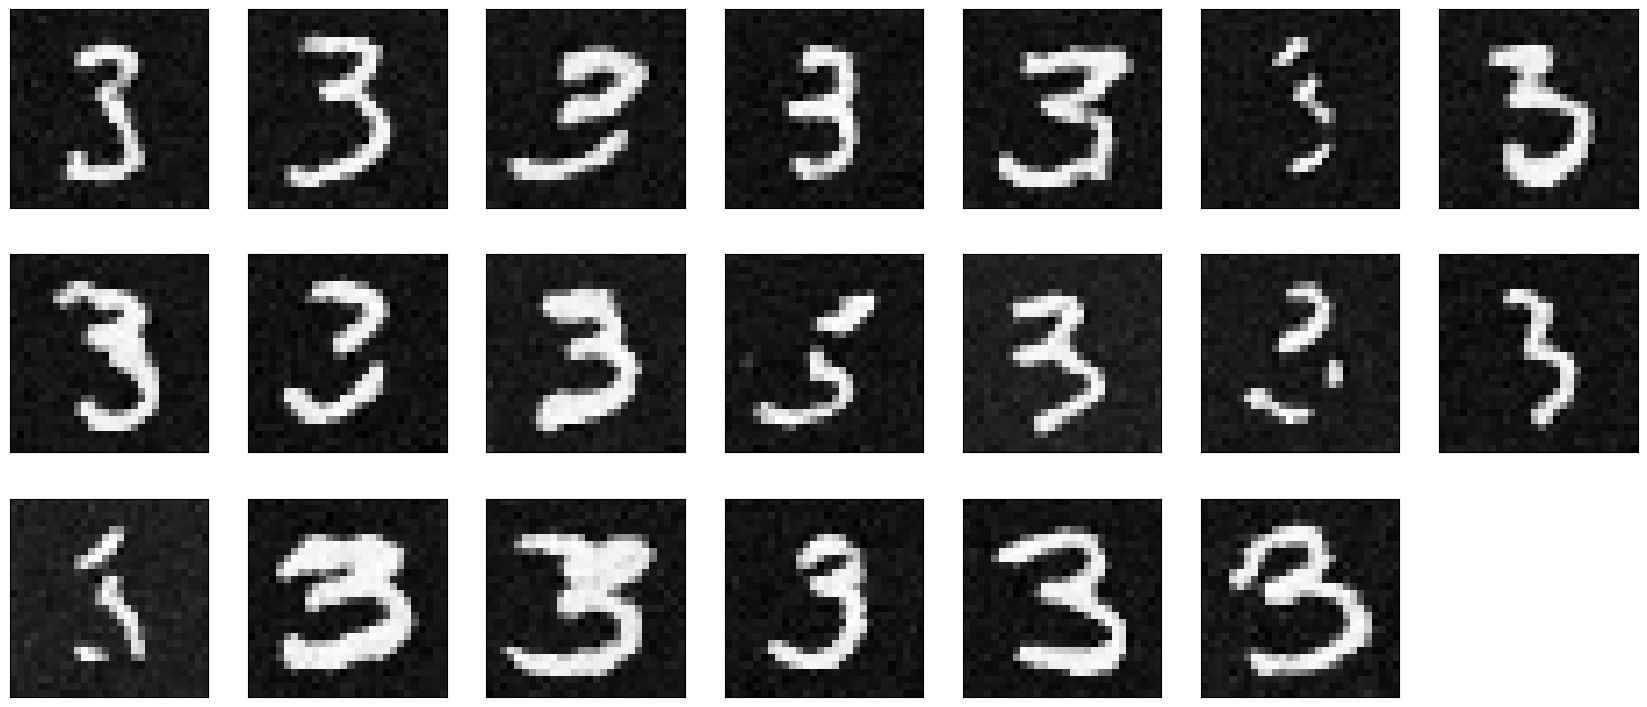

In [16]:
nrows, ncols = 3, 7
plt.figure(figsize=(3 * ncols, 3 * nrows))
for i in range(samples.shape[0]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(1 - samples[i].detach().cpu().numpy(), cmap="Greys")
    plt.xticks([])
    plt.yticks([])